# End to end image classification workflow with distributed training
The following example demonstrates an end to end data science workflow for building an an image classifier <br>
The model is trained on an images dataset of cats and dogs. Then the model is deployed as a function in a serving layer <br>
Users can send http request with an image of cats/dogs image and get a respond back that identify whether it is a cat or a dog

This typical data science workflow comprises of the following:
* Download anb label the dataset
* Training a model on the images dataset
* Deploy a function with the new model in a serving layer
* Testing the function

Key technologies:
* Keras and TensorFlow for training the model
* Horovod for running a distributed training
* MLRun (open source library for tracking experiments https://github.com/mlrun/mlrun) for building the functions and tracking experiments
* Nuclio function for creating a funciton that runs the model in a serving layer

This demo is based on the following:<br>
* https://github.com/tensorflow/docs/tree/master/site/en/tutorials
* https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification/log

In [1]:
# nuclio: ignore
import nuclio

In [2]:
#!pip install kfp

In [3]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


## Helper functions for downloading and labeling images
In the code below we have two functions: 
1. open_archive - Get and extract a zip file that contains cats and dog images. users need to pass the source URL and the target directory which is stored in Iguazio data layer
2. categories_map_builder - labeling the dataset based on the file name. the functions creates a pandas dataframe with the filename and category (i.e. cat & dog)

Note that sometime after running pip install you need to restart the jupyer kernel

In [4]:
import os
import zipfile
import json
from tempfile import mktemp
import pandas as pd


def open_archive(context, 
                 target_dir='content',
                 archive_url=''):
    """Open a file/object archive into a target directory"""
        
    # Define locations
    os.makedirs(target_dir, exist_ok=True)
    context.logger.info('Verified directories')
    
    # Extract dataset from zip
    context.logger.info('Extracting zip')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(target_dir)
    zip_ref.close()
    
    context.logger.info(f'extracted archive to {target_dir}')
    context.log_artifact('content', target_path=target_dir)

    
from mlrun.artifacts import TableArtifact

def categories_map_builder(context,
                           source_dir,
                           df_filename='file_categories_df.csv',
                           map_filename='categories_map.json'):
    """Read labeled images from a directory and create category map + df
    
    filename format: <category>.NN.jpg"""
    
    # create filenames list (jpg only)
    filenames = [file for file in os.listdir(source_dir) if file.endswith('.jpg')]
    categories = []
        
    # Create a pandas DataFrame for the full sample
    for filename in filenames:
        category = filename.split('.')[0]
        categories.append(category)

    df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })
    df['category'] = df['category'].astype('str')
    
    categories = df.category.unique()
    categories = {i: category for i, category in enumerate(categories)}
    with open(os.path.join(context.out_path, map_filename), 'w') as f:
        f.write(json.dumps(categories))
        
    context.logger.info(categories)
    context.log_artifact('categories_map', src_path=map_filename)
    context.log_artifact(TableArtifact('file_categories', df=df, src_path=df_filename))

/User/.pythonlibs/lib/python3.6/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as mlrun.db.sqldb.Label, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


In [5]:
# nuclio: end-code

# Complete Data-Science Pipeline with MLRun

We are using a library called MLRun for running the functions and storing the experiments meta data in the MLRun database <br>
Users can query the database to view all the experiments along with their associated meta data <br>
- Get data
- Create categories map
- Train horovod model on the cluster
- Deploy model

Set the MLRun database location and the base directory

In [6]:
from mlrun import new_function, code_to_function, get_run_db, mount_v3io, NewTask, mlconf, new_model_server
mlconf.dbpath = 'http://mlrun-api:8080'

In [7]:
base_dir = '/User/mlrun/examples'
#base_dir = os.getcwd()
images_path = os.path.join(base_dir, 'images')

### Step 1: Download and extract image archive
The dataset is taken from the Iguazio-sample bucket in S3 <br>
>Note that this step is captured in the MLRun database. <br>

We define a `NewTask` with the `open_archive` function handler and the needed parameters.  
We then use a Local Runtime (the default for new functions) to run the task.

In [8]:
# download images from s3 using the local `open_archive` function
open_archive_task = NewTask('download', handler=open_archive, 
               params={'target_dir': images_path},
               inputs={'archive_url': 'http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip'})
open_archive_fn = new_function().run(open_archive_task)

[mlrun] 2019-12-27 09:43:39,556 downloading http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip to local tmp
[mlrun] 2019-12-27 09:43:41,126 Verified directories
[mlrun] 2019-12-27 09:43:41,126 Extracting zip
[mlrun] 2019-12-27 09:43:58,509 extracted archive to /User/mlrun/examples/images

[mlrun] 2019-12-27 09:43:41,126 Verified directories
[mlrun] 2019-12-27 09:43:41,126 Extracting zip
[mlrun] 2019-12-27 09:43:58,509 extracted archive to /User/mlrun/examples/images



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...f0a458,0,Dec 27 09:43:39,completed,download,host=jupyter-ts5x7vvgam-fri1h-658b7b568f-zl7xv,archive_url,target_dir=/User/mlrun/examples/images,,content


to track results use .show() or .logs() or in CLI: 
!mlrun get run 5bf3f665c69b4630a38e1a50c1f0a458  , !mlrun logs 5bf3f665c69b4630a38e1a50c1f0a458 
[mlrun] 2019-12-27 09:43:58,600 run executed, status=completed


### Step 2: Tag Images with Categories (cat & dog)

We define a `NewTask` with the `categories_map_builder` function handler and the needed parameters.  
We then use a Local Runtime (the default for new functions) to run the task.

In [9]:
# Create categories map
label_task = NewTask('label', handler=categories_map_builder, out_path=images_path,
                              params={'source_dir': os.path.join(images_path, 'cats_n_dogs')})
labeler_function = new_function().run(label_task)

[mlrun] 2019-12-27 09:43:58,678 {0: 'cat', 1: 'dog'}

[mlrun] 2019-12-27 09:43:58,678 {0: 'cat', 1: 'dog'}



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...61fa9b,0,Dec 27 09:43:58,completed,label,host=jupyter-ts5x7vvgam-fri1h-658b7b568f-zl7xv,,source_dir=/User/mlrun/examples/images/cats_n_dogs,,categories_mapfile_categories


to track results use .show() or .logs() or in CLI: 
!mlrun get run 78bab1da31be44558cf8f1234a61fa9b  , !mlrun logs 78bab1da31be44558cf8f1234a61fa9b 
[mlrun] 2019-12-27 09:43:58,798 run executed, status=completed


### Step 3: Distributed Training with TensorFlow, Keras and Horovod

Here we use the same structure as before to deploy our [cats vs. dogs tensorflow model training file](horovod-training.py) to run on the defined horovod cluster in a distributed manner.  

We define the input parameters for the training function.  
We set the function's `kind='mpijob'` to let MLRun know to apply the job to the MPI CRD and create the requested horovod cluster.  
We set the number of workers for the horovod cluster to use by setting `trainer.spec.replicas = 4` (default is 1 replica).  
We set the number of GPUs each worker will receive by setting `trainer.gpus(1)` (default is 0 GPUs).

In [10]:
code_dir = os.getcwd()
HOROVOD_FILE = os.path.join(code_dir, 'horovod-training.py')

params = {
    'checkpoints_dir' : os.path.join(base_dir, 'checkpoints'),
    'model_path' : os.path.join(base_dir, 'models/cats_n_dogs.h5'),
    'epochs' : 3,
    'batch_size' : 64,
    'image_width': 128,
    'image_height': 128,
    'image_channels': 3
}

inputs = {
    'data_path' : os.path.join(images_path, 'cats_n_dogs'),    
    'categories_map': labeler_function.outputs['categories_map'],
    'file_categories': labeler_function.outputs['file_categories']
}

image = 'mlrun/mpijob:latest'
trainer = new_function(name='horovod-trainer',
                       kind='mpijob',
                       command=HOROVOD_FILE, 
                       image=image)
trainer.apply(mount_v3io())
trainer.spec.image_pull_policy = 'Always'
trainer.spec.replicas = 4
# trainer.gpus(1)
mprun = trainer.run(name='train', params=params, out_path='/User/mlrun', inputs=inputs, watch=True)

[mlrun] 2019-12-27 09:44:01,756 starting run train uid=87aa82e0443240c8b388b6a455a6490c  -> http://mlrun-api:8080
+ POD_NAME=train-c3e1d875-worker-1
+ shift
+ /opt/kube/kubectl exec train-c3e1d875-worker-1 -- /bin/sh -c     PATH=/usr/local/bin:$PATH ; export PATH ; LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH ; export LD_LIBRARY_PATH ; DYLD_LIBRARY_PATH=/usr/local/lib:$DYLD_LIBRARY_PATH ; export DYLD_LIBRARY_PATH ;   /usr/local/bin/orted -mca ess "env" -mca ess_base_jobid "3871408128" -mca ess_base_vpid 2 -mca ess_base_num_procs "5" -mca orte_node_regex "train-c[1:3]e1d875-launcher-6m2sb,train-c[1:3]e1d875-worker-0,train-c[1:3]e1d875-worker-1,train-c[1:3]e1d875-worker-2,train-c[1:3]e1d875-worker-3@0(5)" -mca orte_hnp_uri "3871408128.0;tcp://10.233.81.176:53662" -mca plm "rsh" --tree-spawn -mca orte_parent_uri "3871408128.0;tcp://10.233.81.176:53662" -mca plm_rsh_agent "/etc/mpi/kubexec.sh" -mca orte_default_hostfile "/etc/mpi/hostfile" -mca pmix "^s1,s2,cray,isolated"
+ POD_NAME=tra

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...a6490c,0,Dec 27 09:44:02,completed,train,kind=mpijobowner=admin,categories_mapdata_pathfile_categories,batch_size=64checkpoints_dir=/User/mlrun/examples/checkpointsepochs=3image_channels=3image_height=128image_width=128model_path=/User/mlrun/examples/models/cats_n_dogs.h5,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run 87aa82e0443240c8b388b6a455a6490c  , !mlrun logs 87aa82e0443240c8b388b6a455a6490c 
[mlrun] 2019-12-27 09:54:56,234 run executed, status=completed


#### Save the training function
We can use the MLRun DB to store functions for later use.  

When calling `trainer.save()`, the files, the function code, deployment parameters and requested inputs and params are saved.
We can then call them from any location connected to the current DB by using `import_function('db://<function-name>)`, as in this case `import_function('db://horovod-trainer')`.

In [11]:
# save our function object to the DB
trainer.save()

### Step 4: Deploy Model Serving Function

In the following cells we use MLRun to deploy a Model Serving Class from the [nuclio-serving-tf-images](nuclio-serving-tf-images.ipynb) notebook and deploy it with the arguments from our current runs.  

Using `filename=<jupyter notebook file>` in the `new_model_server` we parse the given Jupyter Notebook and build our model server from it.

> All the annotations given in the notebook will be parsed and saved to the function normally

The model server will deploy the model given under `models={<model_name>:<model_file_path>}` as `model_class=<model_class_name>` .  
Just like any other MLRun function we can set our environment variables, workers and add mounts.

The model server will provide us with a `/<model_name>/predict` endpoint where we can query the model.

After we finish setting up the function parameters, we deploy it to the appropriate project using `deploy()`.

In [29]:
model_name = 'cat_dog_v1'

In [36]:
# convert the notebook code to a model server and configure it
inference_function = new_model_server('tf-images-server', 
                                      filename='./nuclio-serving-tf-images.ipynb',
                                      model_class='TFModel',
                                      models={model_name: params['model_path']})
inference_function.set_env('classes_map', labeler_function.outputs['categories_map'])
inference_function.with_http(workers=2).apply(mount_v3io())
addr = inference_function.deploy(project='nuclio-serving')

[mlrun] 2019-12-27 11:26:13,705 deploy started
[nuclio] 2019-12-27 11:26:14,779 (info) Building processor image
[nuclio] 2019-12-27 11:26:19,825 (info) Build complete
[nuclio] 2019-12-27 11:26:27,891 (info) Function deploy complete
[nuclio] 2019-12-27 11:26:27,895 done updating tf-image-serving, function address: 3.18.11.15:32243


## Test the serving function

After the function has been deployed we can test it as a regular REST Endpoint using `requests`.

In [37]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

### Define test params

Test image:


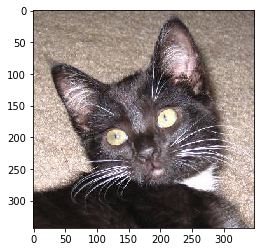

In [38]:
# Testing event
cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.102.jpg'
response = requests.get(cat_image_url)
cat_image = response.content
img = Image.open(BytesIO(cat_image))

print('Test image:')
plt.imshow(img)

### Test The Serving Function (with Image URL)

In [39]:
headers = {'Content-type': 'text/plain'}
response = requests.post(url=addr + f'/{model_name}/predict', data=json.dumps({'data_url': cat_image_url}), headers=headers)
print(response.content.decode('utf-8'))

{"prediction": ["cat"], "dog-probability": [5.120136376049147e-33]}


### Test The Serving Function (with Jpeg Image)

In [40]:
headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=addr + f'/{model_name}/predict', data=cat_image, headers=headers)
print(response.content.decode('utf-8'))

{"prediction": ["cat"], "dog-probability": [5.120136376049147e-33]}
